In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
from MyFunctions import create_times, promo_price_cleaner, product_category, convert_price, common_orders

In [ ]:
pd.set_option('display.max_rows', 1000)
pd.set_option("display.max_colwidth", 100)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [ ]:
# Creating a Funtion for a shareable link from Google
def gd_path(file_id):
    """Generate a shareable link from Google Drive file id."""
    return f"https://drive.google.com/uc?export=download&id={file_id}"


# Google Drive file ids
files_id = {
    "brands": "1m1ThDDIYRTTii-rqM5SEQjJ8McidJskD",
    "orderlines": "1FYhN_2AzTBFuWcfHaRuKcuCE6CWXsWtG",
    "orders": "1Vu0q91qZw6lqhIqbjoXYvYAQTmVHh6uZ",
    "products":"1afxwDXfl-7cQ_qLwyDitfcCx3u7WMvkU"
}

# Reading in the data
brands = pd.read_csv(gd_path(files_id['brands']), sep =',')
orderlines = pd.read_csv(gd_path(files_id['orderlines']), sep =',')
orders = pd.read_csv(gd_path(files_id['orders']), sep =',')
products = pd.read_csv(gd_path(files_id['products']), sep =',')

In [ ]:
brands_gr = brands.copy()
orders_gr = orders.copy()
orderlines_gr = orderlines.copy()
products_gr = products.copy()

# Data Cleaning

In [ ]:
# @title Cleaning Brands table
brands_gr = brands_gr.drop(brands_gr[brands_gr['long'] == 'Unknown'].index)
brands_gr = brands_gr.drop(brands_gr[brands_gr['short'] == 'CAD'].index)
brands_gr.loc[brands_gr['short'] == 'MUJ', 'long']= 'Mujjo'
brands_gr.loc[brands_gr['short'] == 'KEN', 'long']= 'Kensington'
clean_brands = brands_gr.copy()

In [ ]:
# @title Cleaning Orders table

orders_gr = orders_gr.drop_duplicates().dropna(subset = 'total_paid')
orders_gr = create_times(orders_gr, 'created_date')
orders_gr['total_paid'] = round(orders_gr['total_paid'], 2)
clean_orders = orders_gr.copy()

In [ ]:
# @title Cleaning Products table

products_gr = products_gr.drop_duplicates().dropna()
products_gr = promo_price_cleaner(products_gr, 'price', 'promo_price')
products_gr = product_category(products_gr,'type', 'desc', 'name')
products_gr['discount'] = products_gr.apply(lambda record: round(((record['price'] - record['new_promo']) / record['price'])*100, 2), axis=1)
products_gr['product_brand'] = products_gr.sku.str.extract('(^\w{3})')
clean_products = products_gr.copy()

In [ ]:
# @title Cleaning Orderlines table

orderlines_gr['unit_price'] = orderlines_gr['unit_price'].astype(str).apply(convert_price)
orderlines_gr = orderlines_gr.loc[orderlines_gr['unit_price'].str.match(r'^\d+\.\d{1,3}$', na=False)]
orderlines_gr['unit_price'] = pd.to_numeric(orderlines_gr['unit_price'])
clean_orderlines = orderlines_gr.copy()

# Data Merging to create a whole database

In [ ]:
def completed_orders(record):
  return record.loc[record['state'].isin(['Completed'])]

In [ ]:
clean_orders_completed = clean_orders.pipe(completed_orders)
common_id_list = list(common_orders(clean_orders_completed, clean_orderlines, 'order_id', 'id_order').id_order)
clean_orders_completed_id = clean_orders_completed[clean_orders_completed['order_id'].isin(common_id_list)]

In [ ]:
clean_orderlines = clean_orderlines[clean_orderlines.sku.isin(list(clean_products.sku.unique()))]
clean_orderlines_id = clean_orderlines[clean_orderlines['id_order'].isin(common_id_list)]

In [ ]:
pay_diff = (clean_orders_completed_id\
            .groupby(['created_date','order_id'], as_index = False)['total_paid']\
            .sum()\
            .merge(clean_orderlines_id, how = 'inner', left_on ='order_id', right_on = 'id_order'))

pay_diff['total_cost'] = pay_diff['unit_price'] * pay_diff['product_quantity']
pay_diff['cost_diff'] = pay_diff['total_paid'] - pay_diff['total_cost']

In [ ]:
# @title Remove Outliers from the table

q1 = pay_diff['cost_diff'].quantile(0.25)
q3 = pay_diff['cost_diff'].quantile(0.75)

iqr = q3 - q1

pay_diff_w_outliers = pay_diff.loc[(pay_diff['cost_diff'] >= (q1 - 1.5*iqr)) & (pay_diff['cost_diff'] <= (q3 + 1*iqr))]

In [ ]:
# @title Merge all relevant Data for further analysis

all_data = pay_diff_w_outliers.merge(
    clean_products,
    how = 'inner',
    right_on = 'sku',
    left_on = 'sku',
    suffixes = ('_orders', '_products')
).merge(
    clean_brands,
    how = 'inner',
    left_on = 'product_brand',
    right_on = 'short'
).dropna()

In [ ]:
all_data=create_times(all_data, 'created_date')

In [ ]:
all_data.to_csv('/content/drive/MyDrive/WBS/cleaned_combined_data', index=False)

# Data Analysis and Visualization

In [ ]:
sales_data = all_data.copy()

In [ ]:
sales_data['promo_cost'] = sales_data['new_promo'].astype(float) * sales_data['product_quantity'].astype(float)
sales_data['price_cost'] = sales_data['price'].astype(float) * sales_data['product_quantity'].astype(float)

In [ ]:
sales_data['new_discount'] = ((sales_data['price_cost'] - sales_data['total_cost'])/sales_data['price_cost']) * 100

In [ ]:
sales_data['discount_type'] = ['Aggressive' if x > 76
                               else 'Heavy' if x > 51
                               else 'Significant' if x > 26
                               else 'Moderate' if x > 11
                               else 'Small' if 20 > x > 0
                               else 'None'
                               for x in sales_data['discount']]

# Data Visualization

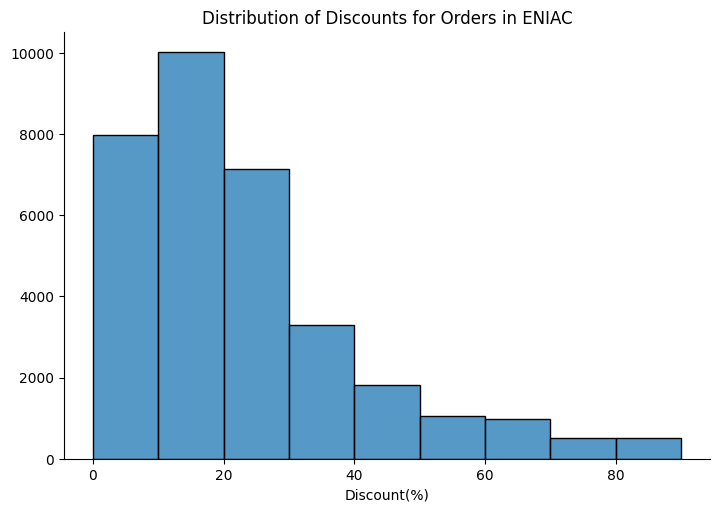

In [ ]:
# @title Distribution of Discounts for Orders in ENIAC

sns.displot(kind='hist', data=sales_data, x='discount', bins=9, aspect=1.5).set(xlabel = 'Discount(%)', ylabel='', title = 'Distribution of Discounts for Orders in ENIAC');

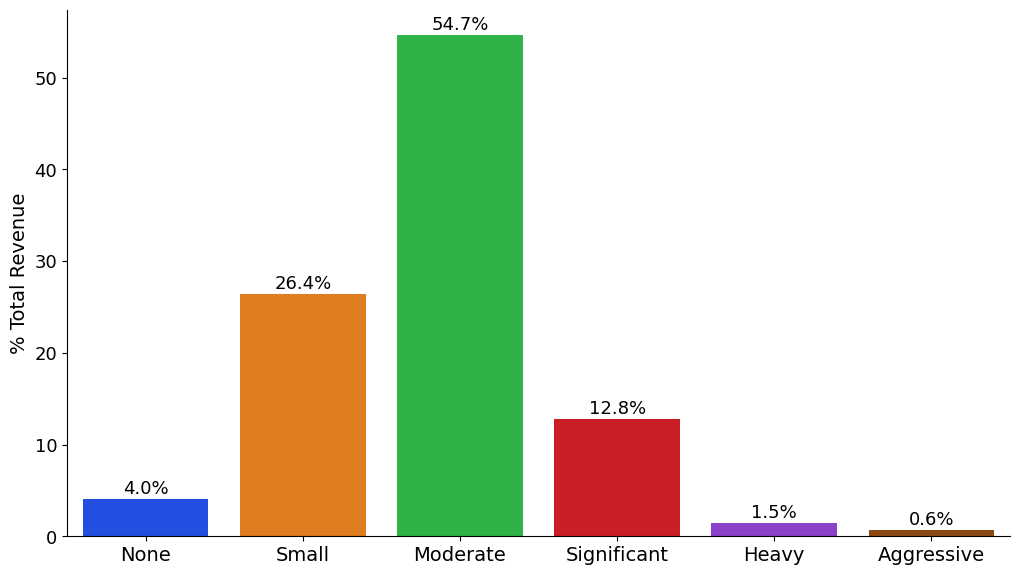

In [ ]:
#@title Revenue Distribution for different Types of Discounts

color_dict = {
    'Moderate': 'red',
    'Small': 'grey',
    'Significant': 'grey',
    'Heavy': 'grey',
    'None': 'blue',
    'Aggressive': 'green'
}

discount_plot = sns.catplot(kind='bar', data=sales_data, x= 'discount_type', y='total_cost', aspect = 1.7, height= 6,
                            order = ['None','Small', 'Moderate', 'Significant','Heavy',  'Aggressive'], palette= 'bright',
                            estimator=(lambda x: sum(x) / sum(sales_data['total_cost']) * 100), errorbar = None);

discount_plot.set(xlabel = '')
discount_plot.tick_params(axis ='x', labelsize=14);
discount_plot.tick_params(axis ='y', labelsize=13);
discount_plot.set_ylabels('% Total Revenue', fontsize=14);
discount_plot.set_titles('Revenue Distribution for different types of discounts',  fontsize= 18);
ax = discount_plot.facet_axis(0, 0)

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 0.6, f'{height:.1f}%', ha="center", fontsize=13)

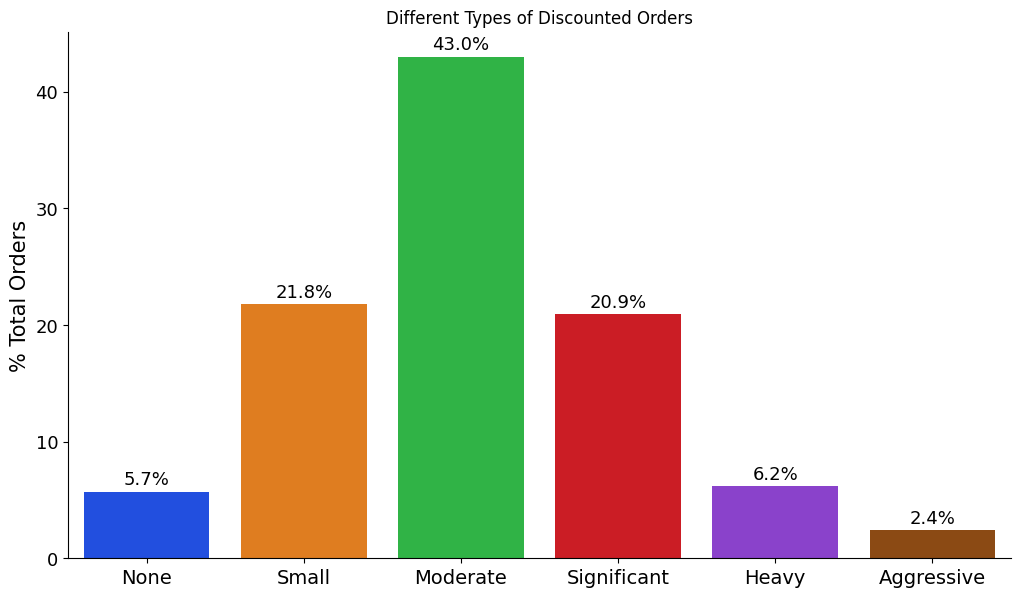

In [ ]:
#@title Orders Distribution for different Types of Discounts

color_dict = {
    'Moderate': 'red',
    'Small': 'grey',
    'Significant': 'grey',
    'Heavy': 'grey',
    'None': 'blue',
    'Aggressive': 'green'
}

discount_plot = sns.catplot(kind='bar', data=sales_data, x= 'discount_type', y='product_quantity', aspect = 1.7, height=6,
                            order = ['None','Small', 'Moderate', 'Significant','Heavy',  'Aggressive'], palette= 'bright',
                            estimator=(lambda x: sum(x) / sum(sales_data['product_quantity']) * 100), errorbar = None);

discount_plot.set(xlabel = '', ylabel='% Total Orders', title = 'Different Types of Discounted Orders');
discount_plot.tick_params(axis ='x', labelsize=14);
discount_plot.tick_params(axis ='y', labelsize=13);
discount_plot.set_ylabels('% Total Orders', fontsize=15);
discount_plot.set_titles('Different Types of Discounted Orders', labelsize=18)
ax = discount_plot.facet_axis(0, 0)

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 0.6, f'{height:.1f}%', ha="center", fontsize=13)
# Show the plot
plt.show()

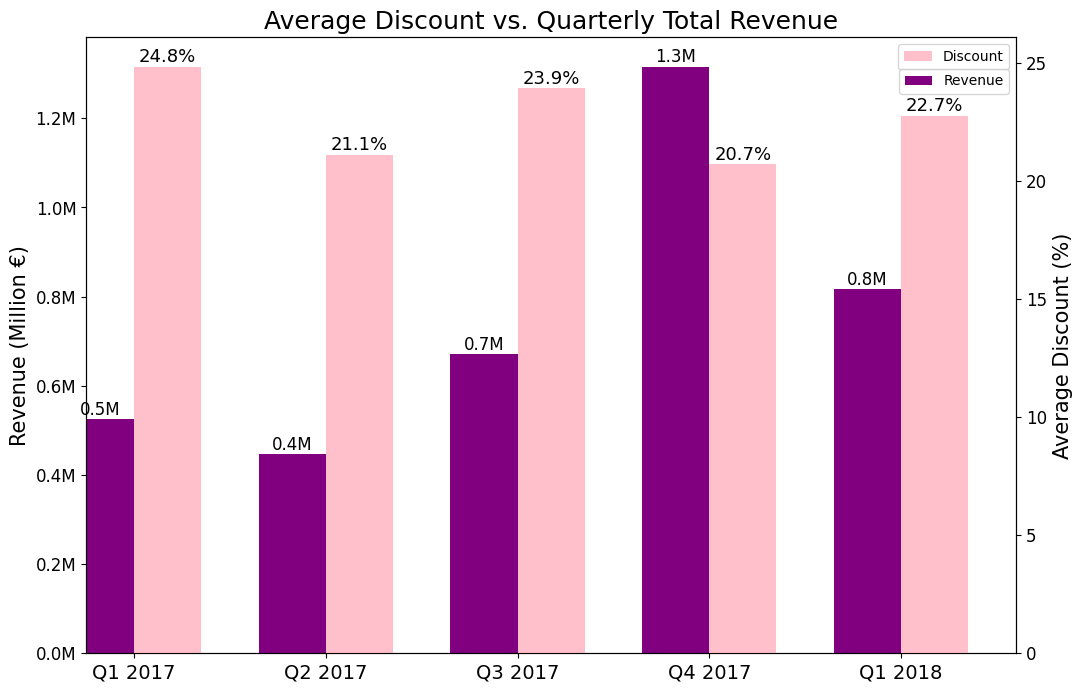

In [ ]:
# @title Quarter Year vs the Revenue vs Discount

fig = plt.figure(figsize=(12,8))

ax = fig.add_subplot(111)
ax2 = ax.twinx()
width =0.35
data = (sales_data.groupby('quarter_year')\
        .agg({'total_cost': 'sum', 'discount':'mean'})\
        .loc[['Q1 2017', 'Q2 2017', 'Q3 2017', 'Q4 2017', 'Q1 2018']])

data.total_cost.plot(kind='bar', color='purple', ax=ax, width=width, position =1, rot=0)
data.discount.plot(kind='bar', color='pink', ax=ax2, position=0, width=width)

ax.set_ylabel('Revenue (Million €)', fontsize=15)

ax2.set_ylabel('Average Discount (%)', fontsize=15)
ax.set_xlabel('')
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=12)
ax2.tick_params(axis='y', labelsize=12)

ax.legend(loc='upper right', bbox_to_anchor=(1.0, 0.96), labels=['Revenue'])
ax2.legend(loc='upper right', bbox_to_anchor=(1.0, 1), labels=['Discount'])

def format_millions(x, pos):
    'The two args are the value and tick position'
    return f'{x * 1e-6:.1f}M'

# Set the y-axis formatter for the revenue bars
ax.yaxis.set_major_formatter(ticker.FuncFormatter(format_millions))

# Annotate each bar with the value
for p in ax.patches:
    height = p.get_height()
    ax.annotate(format_millions(height, None), xy=(p.get_x() + p.get_width() / 2, height),
                xytext=(0, 3), textcoords='offset points', ha='center', fontsize=12)

for p in ax2.patches:
    height = p.get_height()
    ax2.text(p.get_x() + p.get_width() / 2., height + 0.2, f'{height:.1f}%', ha="center", fontsize=13)

plt.title('Average Discount vs. Quarterly Total Revenue', fontsize=18)
plt.show()



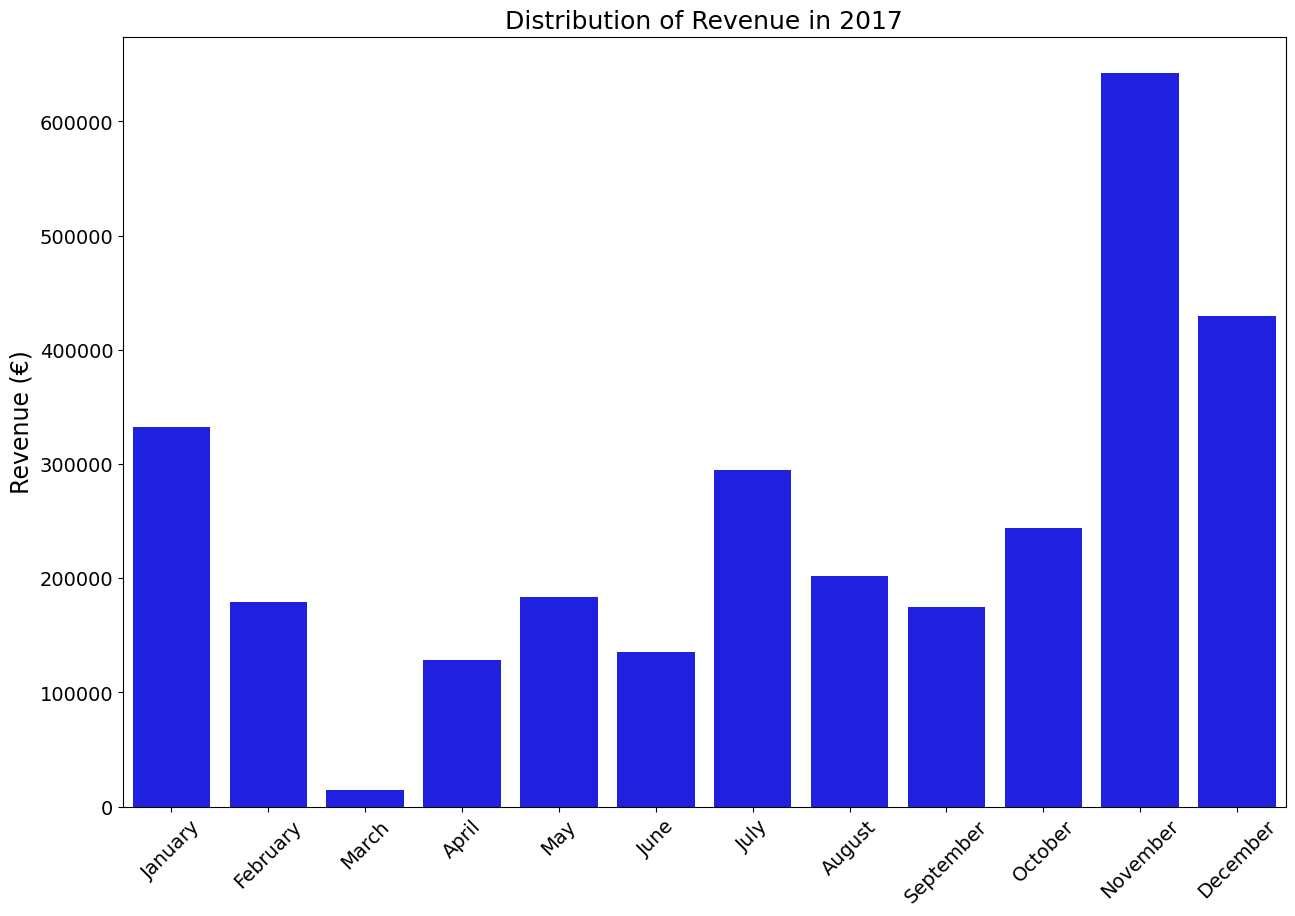

In [ ]:
# @title Distribution of Revenue across various months in the year 2017


revenue_by_month = sales_data[sales_data['year']==2017].groupby('month')['total_cost'].sum().reset_index()

plt.figure(figsize=(15, 10))

months = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']

sns.barplot(data=revenue_by_month, x='month', y='total_cost', order=months, color='blue')

plt.title('Distribution of Revenue in 2017', fontsize = 18)
plt.xlabel('')
plt.ylabel('Revenue (€)', fontsize= 17)

plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)

# Show the plot
plt.show()


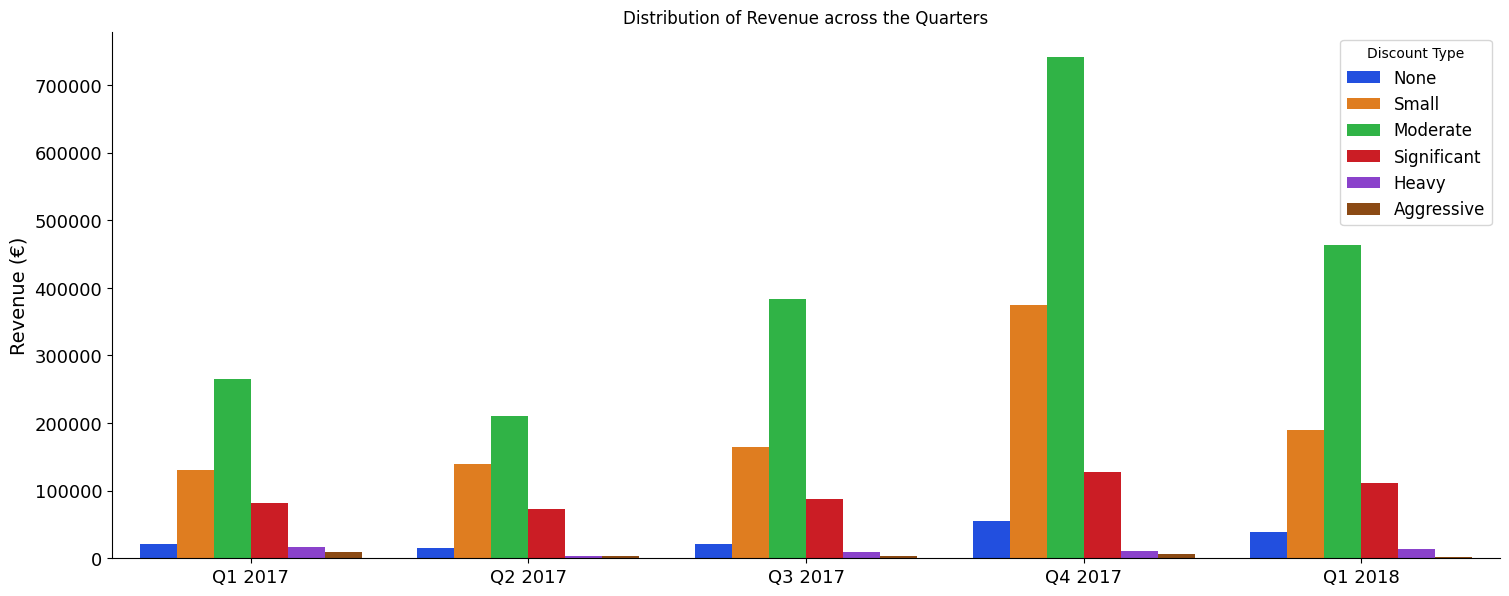

In [ ]:
# @title Quarterly Distribution of Revenue across different discount types
quarters = ['Q1 2017', 'Q2 2017', 'Q3 2017', 'Q4 2017', 'Q1 2018']

plott1 = sns.catplot(data=sales_data, kind='bar',
                    x= 'quarter_year', y='total_cost', hue='discount_type',
                    palette='bright', errorbar=None, aspect = 2.5, height= 6,
                     estimator = sum, order=quarters, legend_out=False,
                     hue_order =['None','Small', 'Moderate', 'Significant','Heavy',  'Aggressive']).set(
                        title='Distribution of Revenue across the Quarters')

plott1.set_ylabels('Revenue (€)', fontsize=14)
plott1.tick_params(axis='both', labelsize=13)
plott1.set_xlabels('')
plt.legend(fontsize=12, loc='upper right', title='Discount Type');

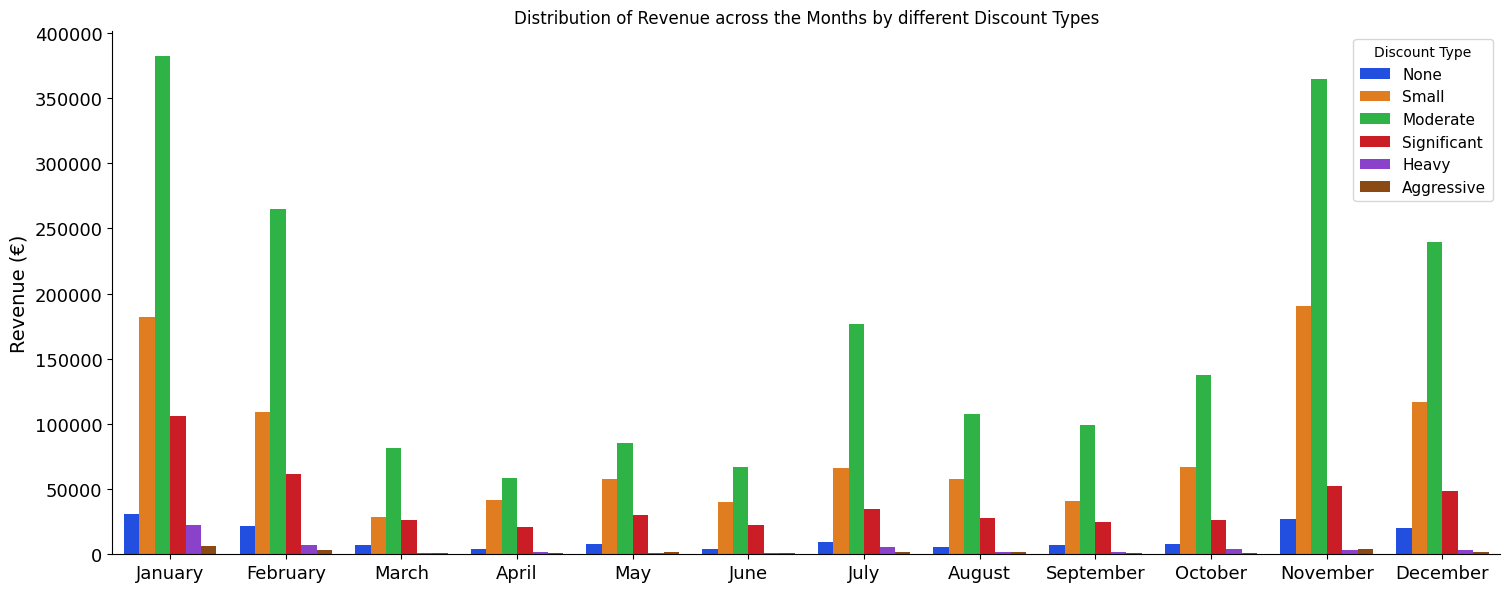

In [ ]:
# @title Monthly Distribution of Revenue across different discount types
months = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']

plott1 = sns.catplot(data=sales_data, kind='bar',
                    x= 'month', y='total_cost', hue='discount_type', hue_order=['None','Small', 'Moderate', 'Significant','Heavy',  'Aggressive'],
                    palette='bright', errorbar=None, aspect = 2.5, height= 6, estimator = sum, order=months, legend_out=False).set(
                        title='Distribution of Revenue across the Months by different Discount Types'
                    );

plott1.set_xlabels('')
plott1.set_ylabels('Revenue (€)', fontsize=14)
plott1.tick_params(axis='both', labelsize=13)
plott1.set_xlabels('')
plt.legend(fontsize=11, loc='upper right', title='Discount Type');

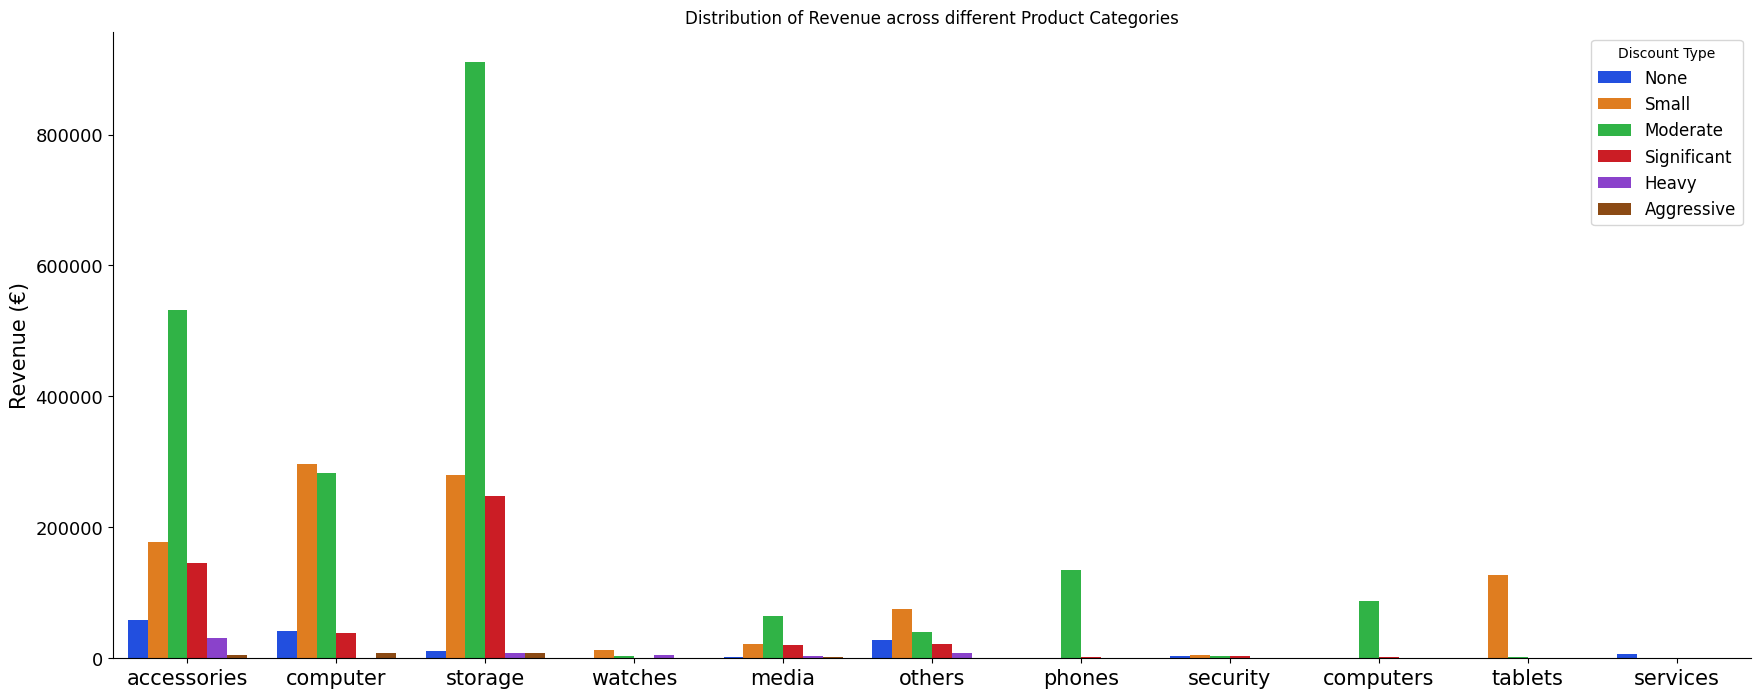

In [ ]:
# @title Distribution of Revenue across different Product Categories

plott = sns.catplot(data=sales_data, kind='bar',
                    x= 'product_category', y='total_cost', hue='discount_type',
                    palette='bright', errorbar=None, estimator=sum, aspect = 2.5, height=7, legend_out=False,
                    hue_order=['None','Small', 'Moderate', 'Significant','Heavy',  'Aggressive'])
plott.set_ylabels('Revenue (€)', fontsize=15)
plott.set_xlabels('', fontsize=15)
plott.tick_params(axis ='x', labelsize=15);
plott.tick_params(axis ='y', labelsize=13);
plt.legend(fontsize=12, loc='upper right', title='Discount Type');
plt.title('Distribution of Revenue across different Product Categories');

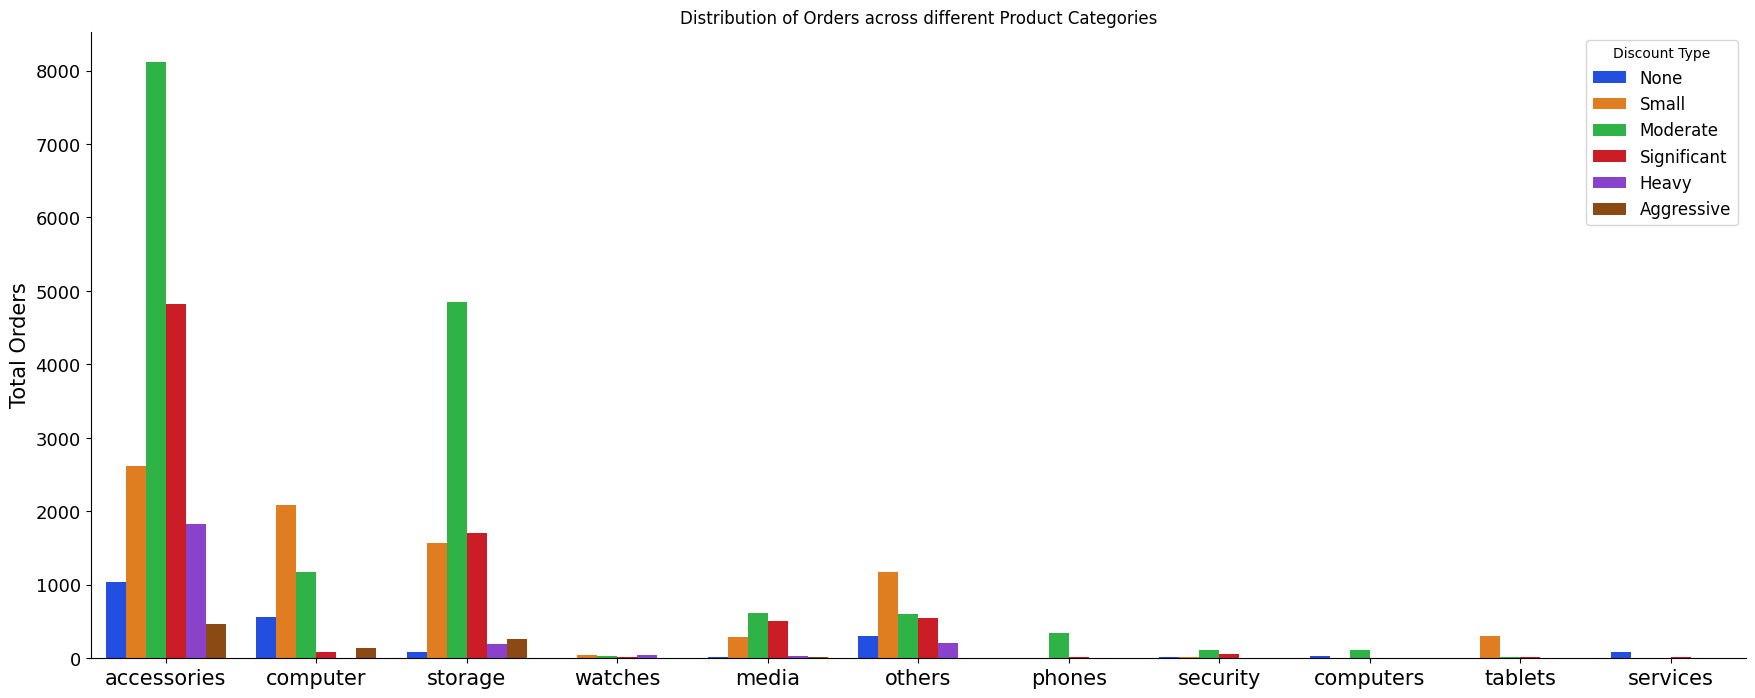

In [ ]:
# @title Distribution of Orders across different Product Categories

plott = sns.catplot(data=sales_data, kind='bar',
                    x= 'product_category', y='product_quantity', hue='discount_type',
                    palette='bright', errorbar=None, estimator=sum, aspect = 2.5, height=7,
                    legend_out=False, hue_order=['None','Small', 'Moderate', 'Significant','Heavy',  'Aggressive'])

plott.set_ylabels('Total Orders', fontsize=15)
plott.set_xlabels('', fontsize=15)
plott.tick_params(axis ='x', labelsize=15);
plott.tick_params(axis ='y', labelsize=13);
plt.legend(fontsize=12, loc='upper right', title='Discount Type');
plt.title('Distribution of Orders across different Product Categories');

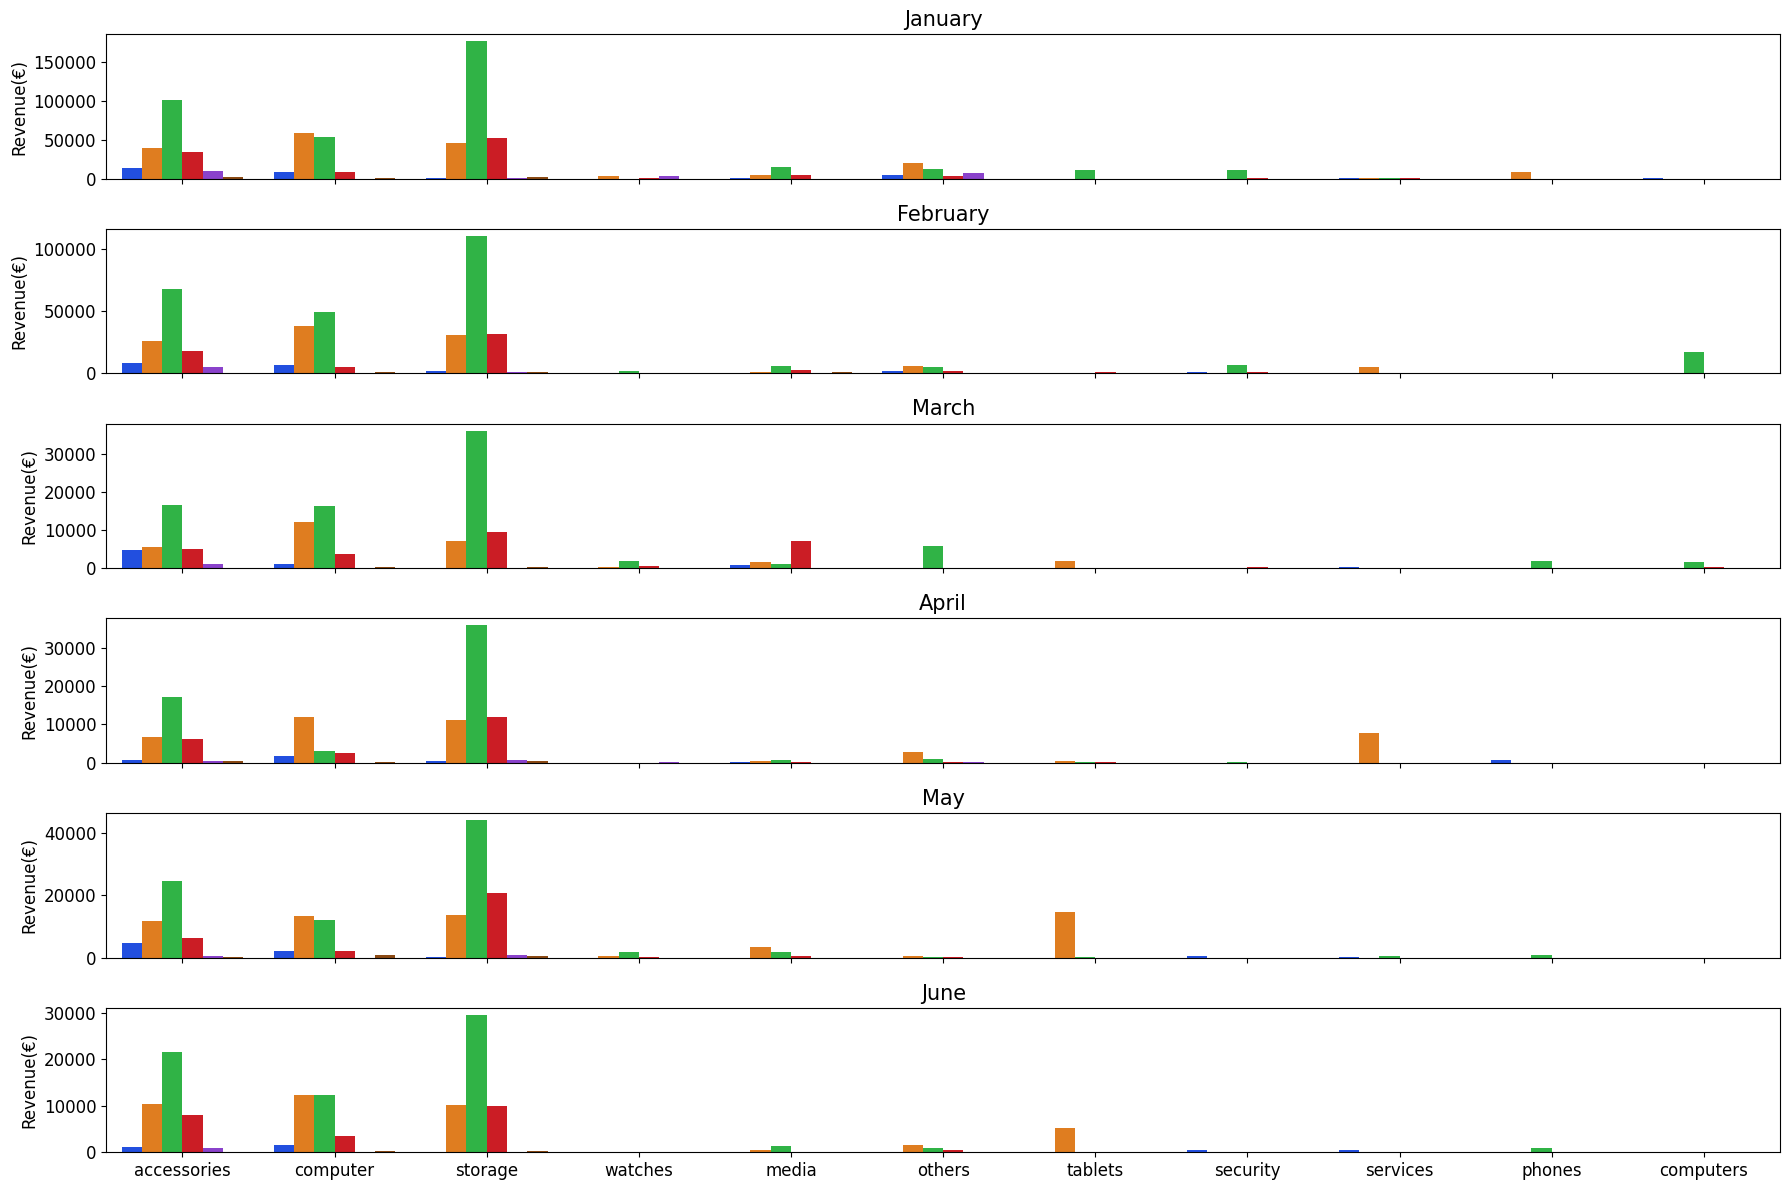

In [ ]:
# @title Monthly Distribution of Revenue across different Product Categories (January - June)

months_order = ['January', 'February', 'March', 'April', 'May', 'June']

# it was sandwiched so i seperated the plots into two

# Create 6 subplots (one for each month)
fig, axes = plt.subplots(nrows=6, figsize=(18, 12), sharex=True)

# Loop through each month and create the corresponding plot
for i, month in enumerate(months_order):
    month_data = sales_data[sales_data['month'] == month]
    sns.barplot(data=month_data, x='product_category', y='total_cost', hue='discount_type',
                palette='bright', errorbar=None, estimator=sum, ax=axes[i],
                hue_order=['None', 'Small', 'Moderate', 'Significant', 'Heavy', 'Aggressive'])

    axes[i].set_title(month, fontsize=15)#, fontweight='bold')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Revenue(€)', fontsize=12)
    axes[i].tick_params(axis='both', labelsize=12)
    axes[i].legend().set_visible(False)  # Remove the legend

# Adjust the layout to prevent overlapping titles and x-axis labels
plt.tight_layout()

# Show the plot
plt.show()

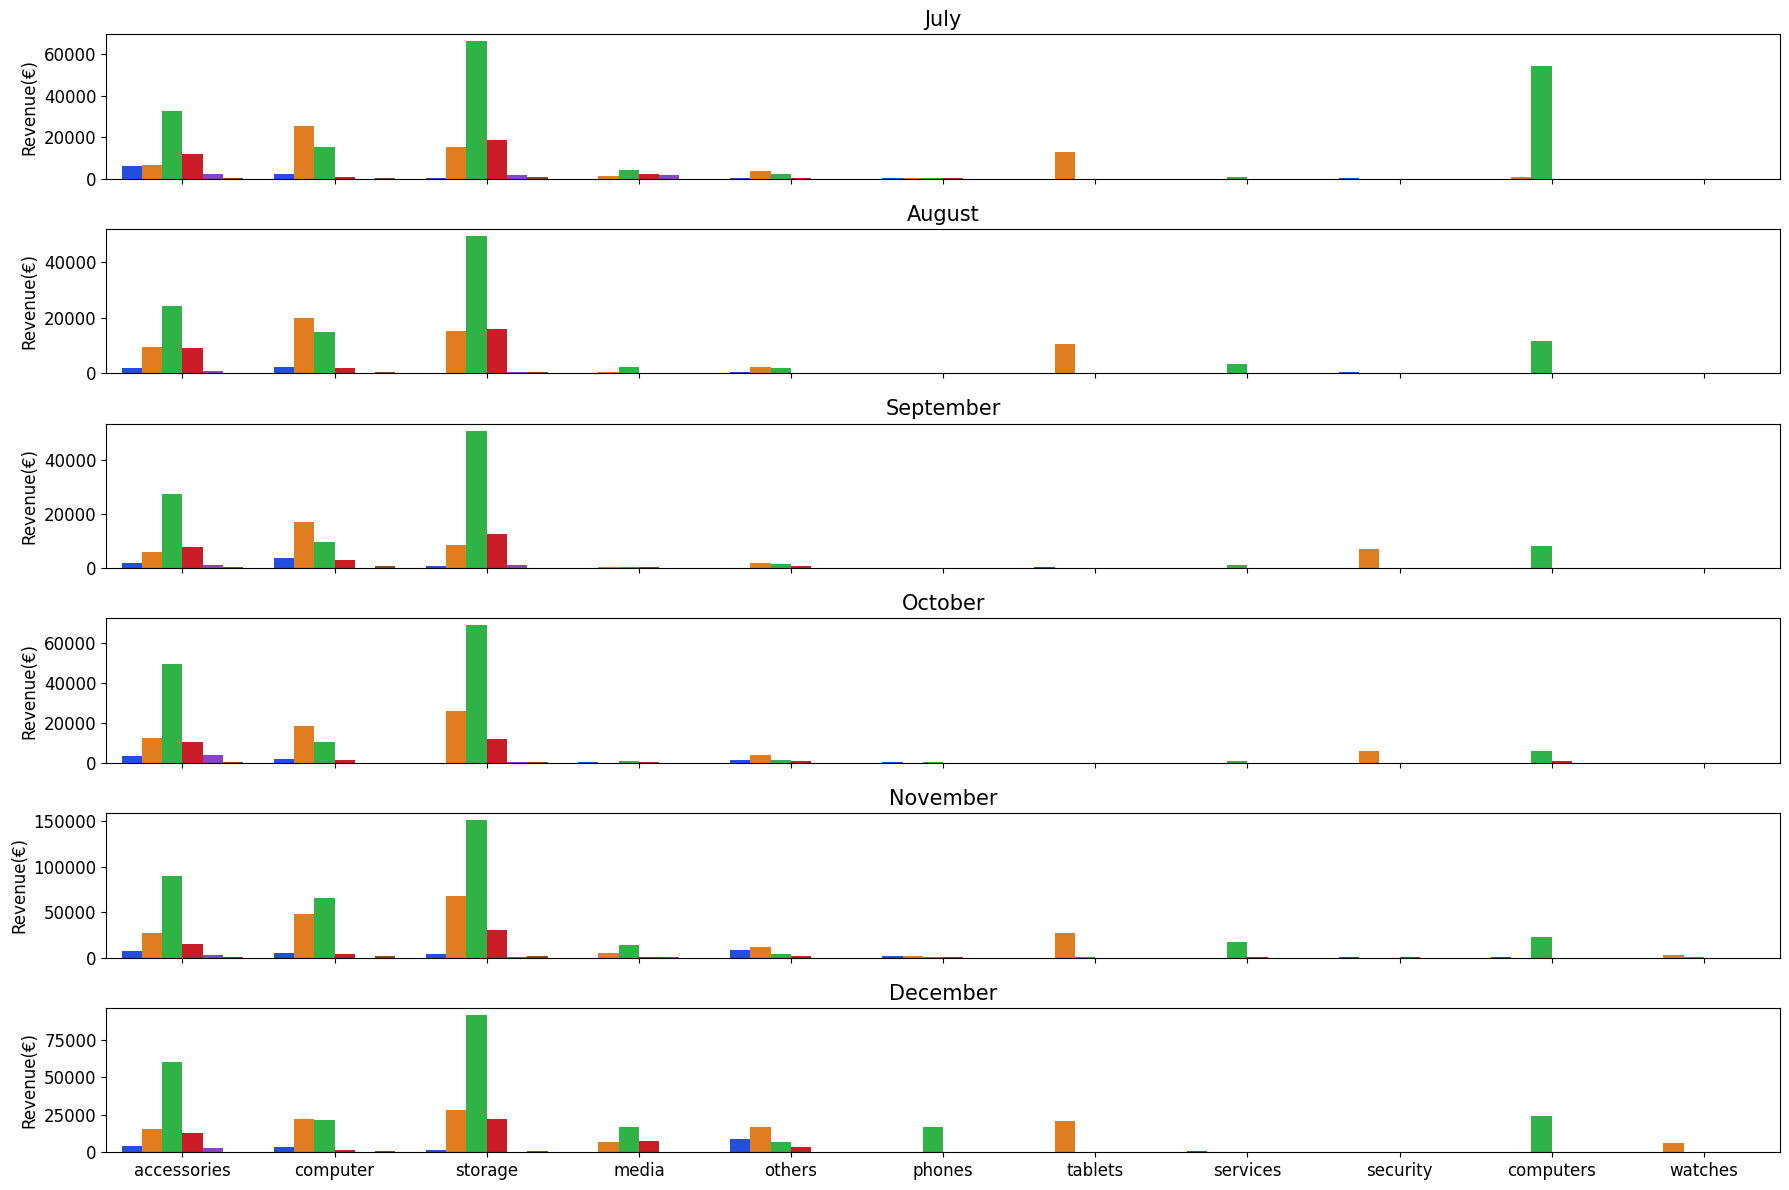

In [ ]:
# @title Monthly Distribution of Revenue across different Product Categories (July - December)

months_order = ['July', 'August', 'September', 'October', 'November', 'December']

# Create 6 subplots (one for each month)
fig, axes = plt.subplots(nrows=6, figsize=(18, 12), sharex=True)


for i, month in enumerate(months_order):
    month_data = sales_data[sales_data['month'] == month]
    sns.barplot(data=month_data, x='product_category', y='total_cost', hue='discount_type',
                palette='bright', errorbar=None, estimator=sum, ax=axes[i],
                hue_order=['None', 'Small', 'Moderate', 'Significant', 'Heavy', 'Aggressive'])
    axes[i].set_title(month, fontsize=15)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Revenue(€)', fontsize=12)
    axes[i].tick_params(axis='both', labelsize=12)
    axes[i].legend().set_visible(False)  # Remove the legend


plt.tight_layout()

plt.show()

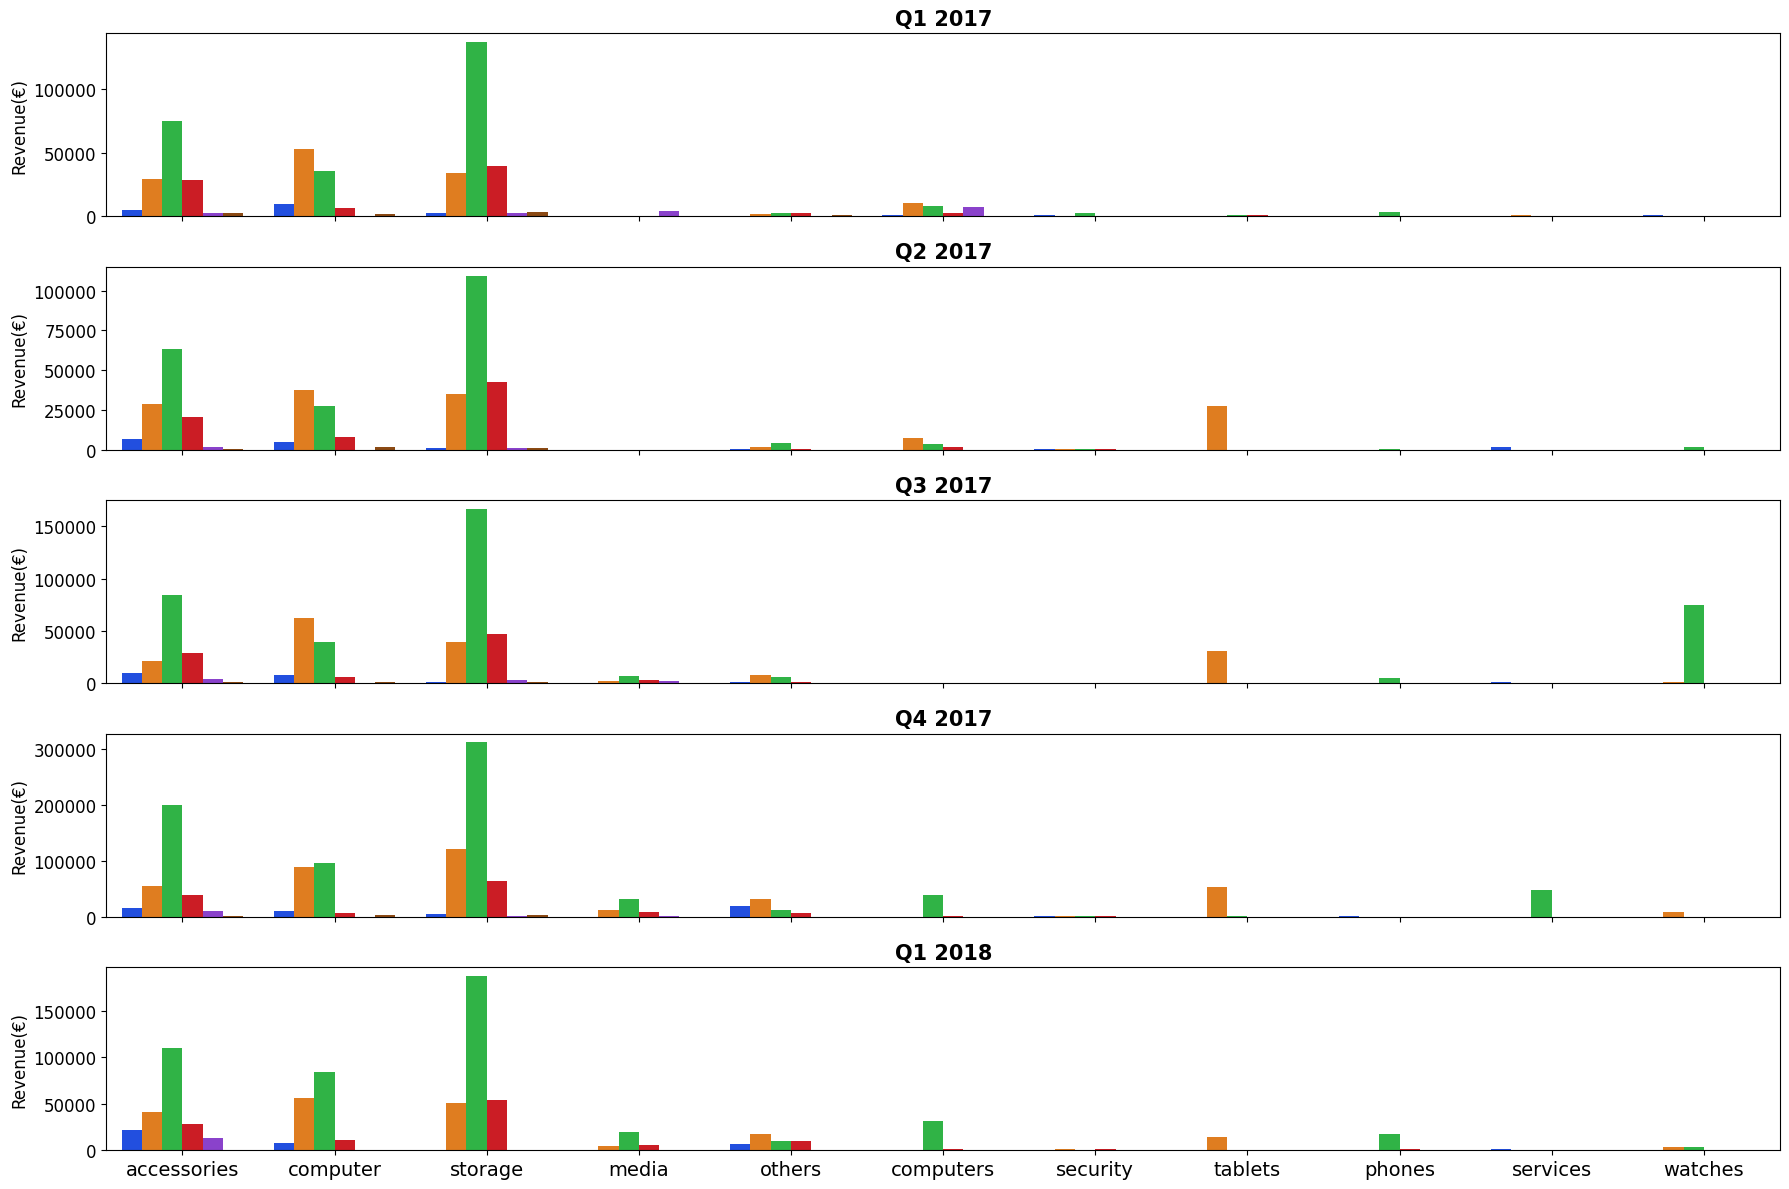

In [ ]:
# @title Quarterly Distribution of Revenue across different Product Categories

quarters_order = ['Q1 2017', 'Q2 2017', 'Q3 2017', 'Q4 2017', 'Q1 2018']

# Create 5 subplots (one for each quarter)
fig, axes = plt.subplots(nrows=5, figsize=(18, 12), sharex=True)


for i, quarter in enumerate(quarters_order):
    quarter_data = sales_data[sales_data['quarter_year'] == quarter]
    sns.barplot(data=quarter_data, x='product_category', y='total_cost', hue='discount_type',
                palette='bright', errorbar=None, estimator=sum, ax=axes[i],
                hue_order=['None', 'Small', 'Moderate', 'Significant', 'Heavy', 'Aggressive'])
    axes[i].set_title(quarter, fontsize=15, fontweight='bold')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Revenue(€)', fontsize=12)
    axes[i].tick_params(axis='y', labelsize=12)
    axes[i].tick_params(axis='x', labelsize=14)
    axes[i].legend().set_visible(False)  # Remove the legend


plt.tight_layout()

plt.show()

<Figure size 640x480 with 0 Axes>

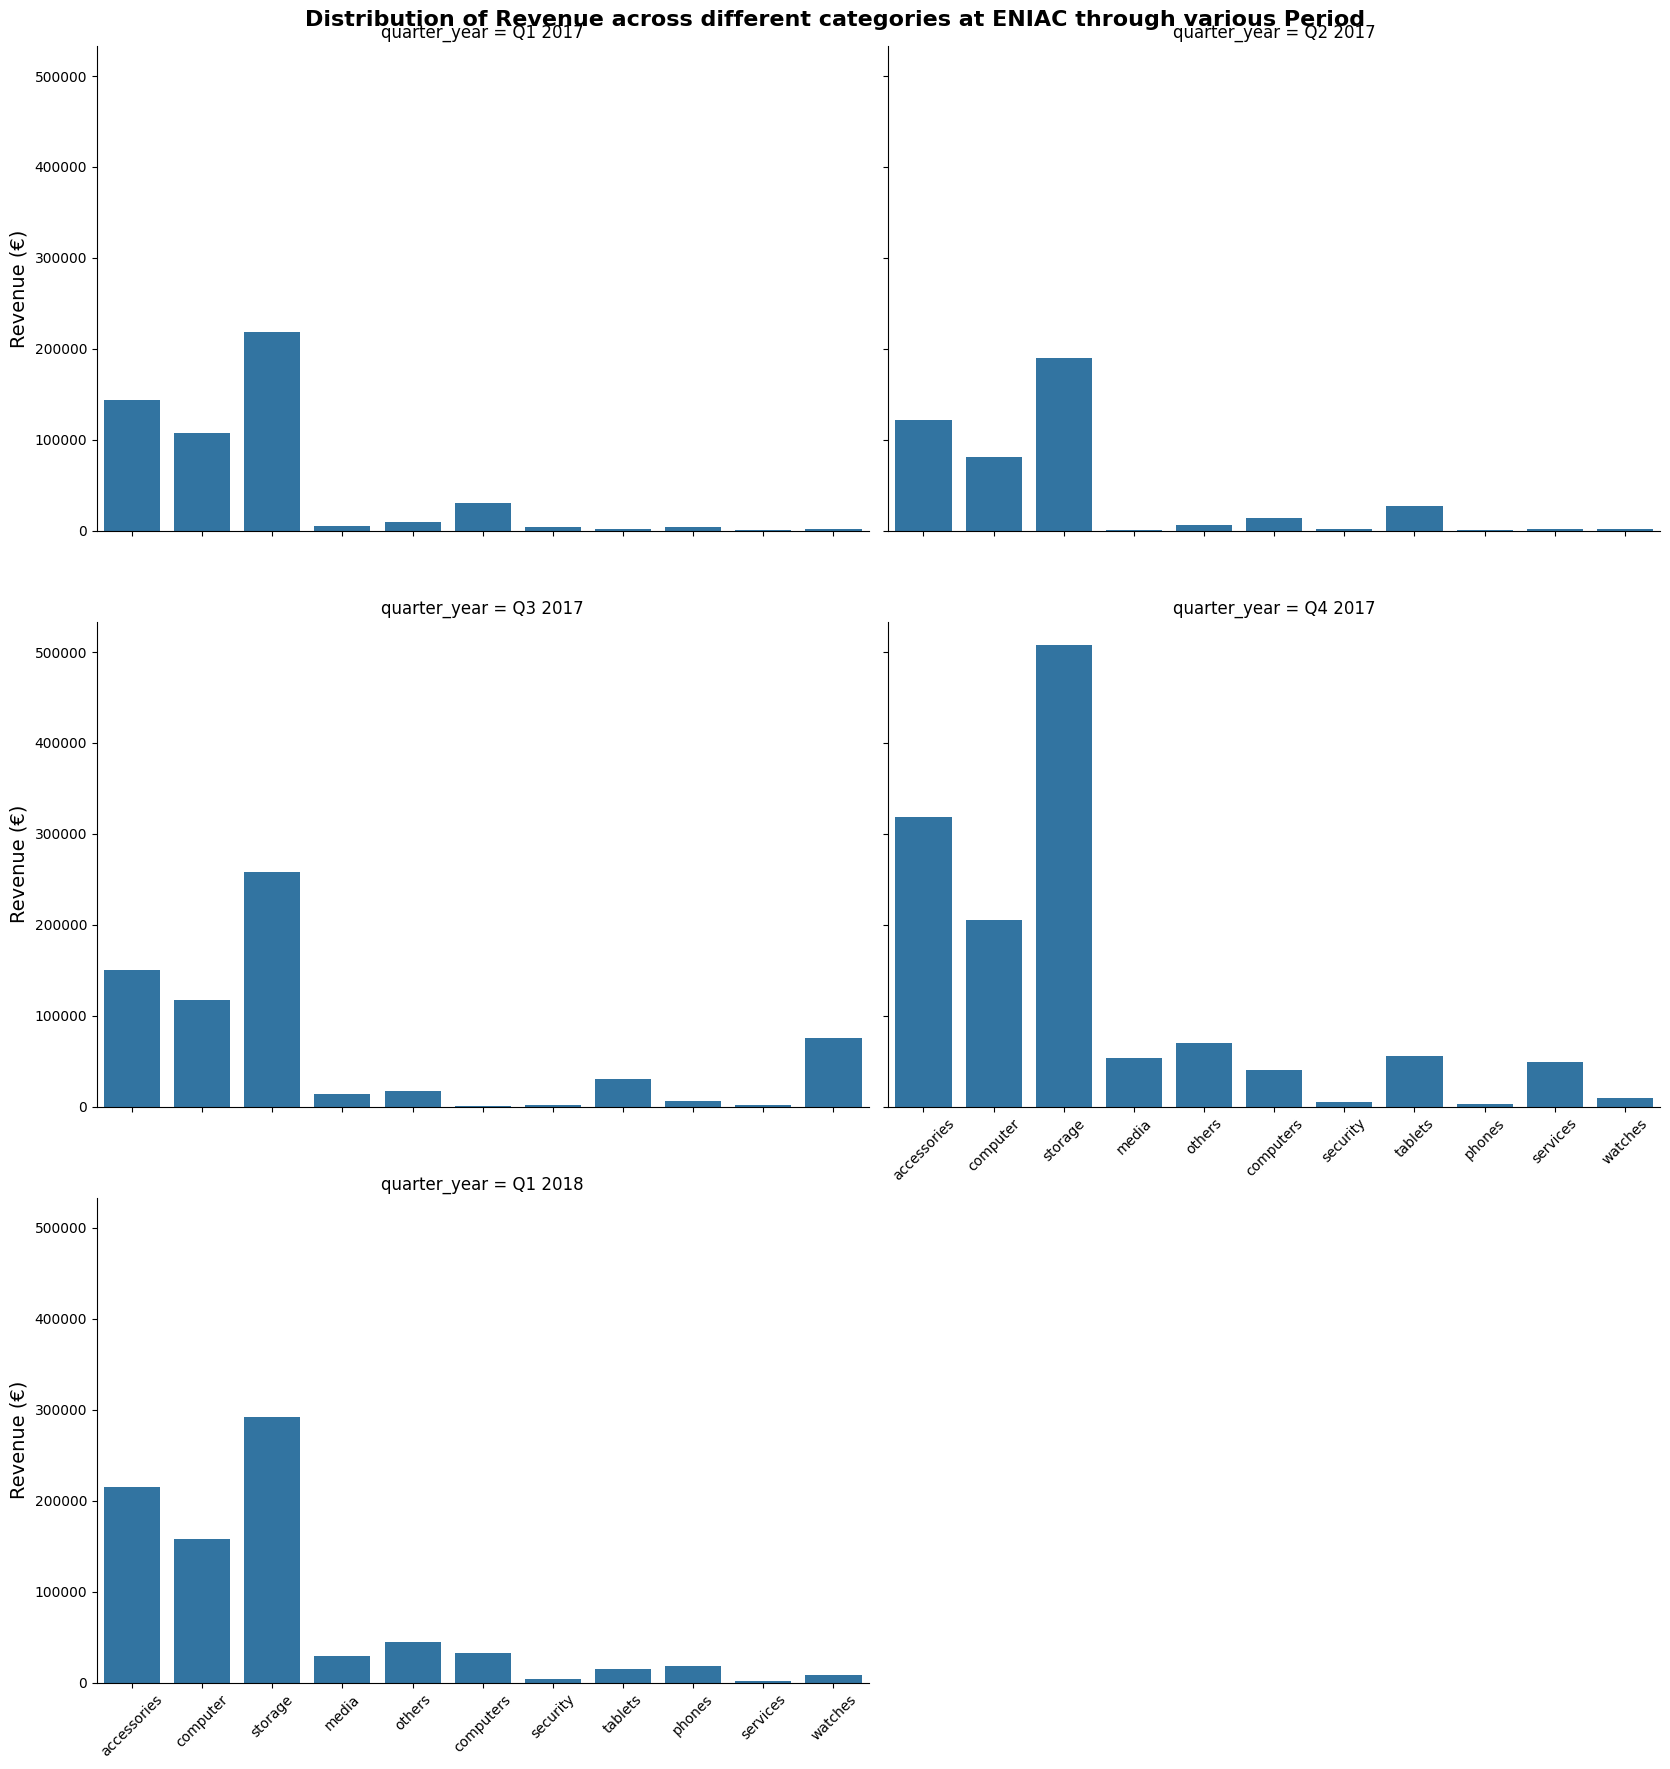

In [ ]:
plt.clf()
facet_plot = sns.FacetGrid(sales_data, col='quarter_year', col_wrap=2, height=6, aspect=1.4);
facet_plot.map_dataframe(sns.barplot, x='product_category', y='total_cost', estimator= sum, errorbar=None);

# Set the x-axis label for each plot
facet_plot.set_xlabels('');
facet_plot.set_ylabels('Revenue (€)', fontsize=14);
facet_plot.fig.suptitle('Distribution of Revenue across different categories at ENIAC through various Period', fontsize=16, fontweight='bold');

# Set the plot title for each plot
for ax in facet_plot.axes:
    ax.set_title(str(ax.get_title()))


# Adjust the spacing between subplots
for ax in facet_plot.axes.flat:
    ax.tick_params(axis='x', labelrotation=45);


facet_plot.fig.subplots_adjust(bottom=0.15);
facet_plot.tight_layout();

# Show the plot
plt.show();


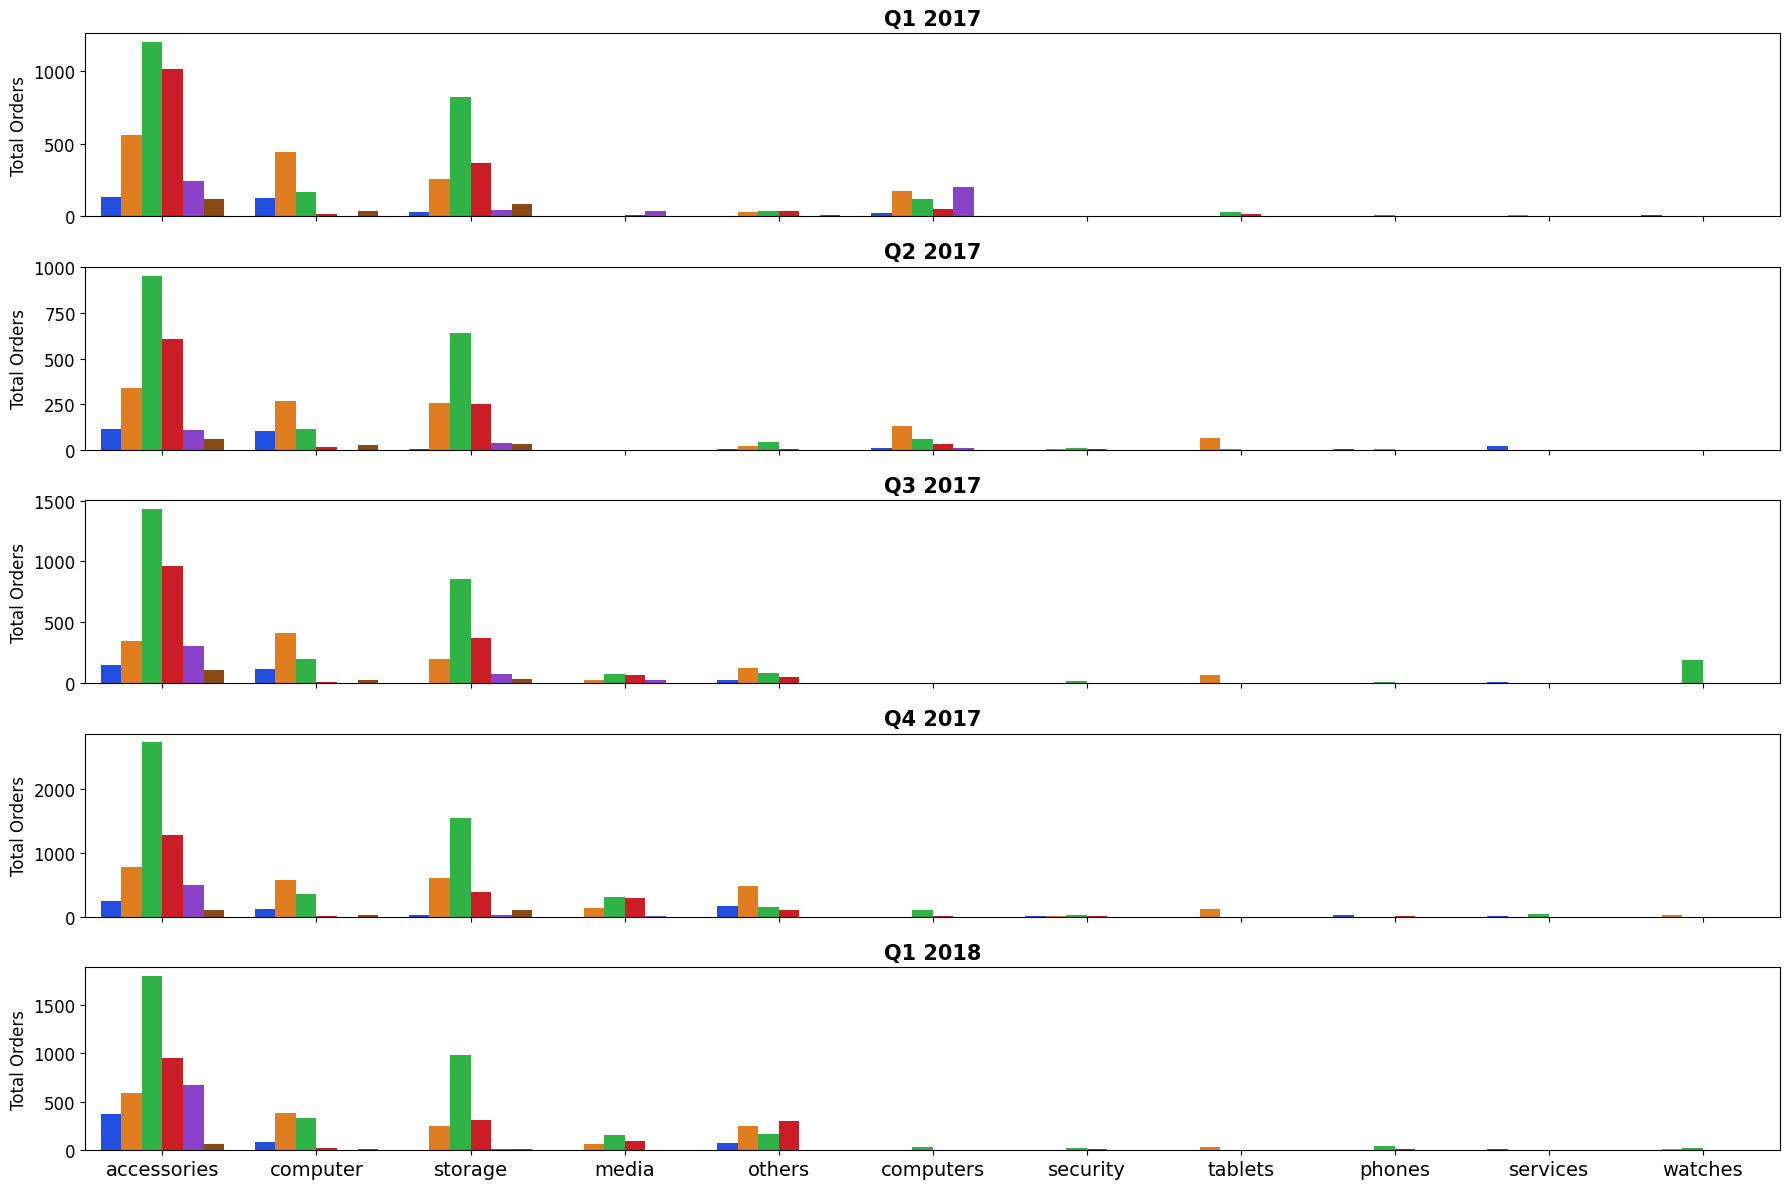

In [ ]:
# @title Quarterly Distribution of Orders across different Product Categories

quarters_order = ['Q1 2017', 'Q2 2017', 'Q3 2017', 'Q4 2017', 'Q1 2018']

# Create 5 subplots (one for each quarter)
fig, axes = plt.subplots(nrows=5, figsize=(18, 12), sharex=True)

for i, quarter in enumerate(quarters_order):
    quarter_data = sales_data[sales_data['quarter_year'] == quarter]
    sns.barplot(data=quarter_data, x='product_category', y='product_quantity', hue='discount_type',
                palette='bright', errorbar=None, estimator=sum, ax=axes[i],
                hue_order=['None', 'Small', 'Moderate', 'Significant', 'Heavy', 'Aggressive'])
    axes[i].set_title(quarter, fontsize=15, fontweight='bold')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Total Orders', fontsize=12)
    axes[i].tick_params(axis='y', labelsize=12)
    axes[i].tick_params(axis='x', labelsize=14)
    axes[i].legend().set_visible(False)  # Remove the legend


plt.tight_layout()

plt.show()